Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

In [23]:
FN = 'vocabulary-embedding'

In [24]:
seed=42

In [56]:
vocab_size = 37000

In [26]:
embedding_dim = 100

In [27]:
lower = True # dont lower case the text

# read tokenized headlines and descriptions

In [28]:
import pickle
FN0 = 'all-the-news' # this is the name of the data file which I assume you already have
with open('data/%s_5000.pickle'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [29]:
n_sentences = 5

In [30]:
if lower:
    heads = [h[0] for h in heads]

In [31]:
if lower:
    desc = [' '.join(h[:n_sentences]).lower() for h in desc]

In [32]:
i=0
heads[i]

'House Republicans Fret About Winning Their Health Care Suit The New York Times'

In [33]:
desc[i]

'congressional republicans have a new fear when it come to their health care lawsuit against the obama administration they might win the incoming trump administration could choose to no longer defend the executive branch against the suit which challenge the administration s authority to spend billion of dollar on health insurance subsidy for and americans handing house republicans a big victory on issue but a sudden loss of the disputed subsidy could conceivably cause the health care program to implode leaving million of people without access to health insurance before republicans have prepared a replacement that could lead to chaos in the insurance market and spur a political backlash just a republicans gain full control of the government to stave off that outcome republicans could find themselves in the awkward position of appropriating huge sum to temporarily prop up the obama health care law angering conservative voter who have been demanding an end to the law for year'

In [34]:
# keywords[i]

In [35]:
len(heads),len(set(heads))

(4997, 4930)

In [36]:
len(desc),len(set(desc))

(4997, 4876)

# build vocabulary

In [37]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = list(map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1])))
    return vocab, vocabcount

In [38]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [39]:
print(list(vocab)[:50])
print('...',len(list(vocab)))


['the', 'a', 'of', 'to', 'and', 'in', 's', 'on', 'that', 'for', 'it', 'The', 'New', 'wa', 'York', 'Times', 'his', 'mr', 'with', 'is', 'at', 'he', 'by', 'trump', 'said', 'an', 'from', 'ha', 'who', 'had', 'but', 'have', 'not', 'be', 'president', 'year', 'her', 'new', 'they', 'are', 'this', 'about', 'their', 'one', 'been', 'after', 'i', 'were', 'or', 'more']
... 37512


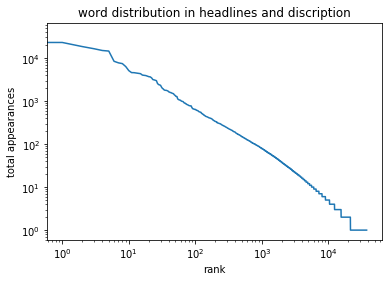

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [41]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [42]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [43]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [44]:
from keras.utils.data_utils import get_file
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
if not os.path.exists(glove_name):
    path = 'glove.6B.zip'
    path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
    !unzip {datadir}/{path}
    # Elaine: Unzip didn't work for me because the datadir and path were duplicated for some reason. I just pulled the extracted files into .keras/dataset folder and omitted this line, in case if it does not work for you either

/home/tang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [45]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [46]:
import numpy as np

glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [47]:
glove_embedding_weights.std()

0.04081572760019029

In [48]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [57]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081313415443376
number of tokens, in small vocab, found in glove and copied to embedding 35736 0.9658378378378378


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [58]:
glove_thr = 0.5

In [59]:
word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [60]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 501


manually check that the worst substitutions we are going to do are good enough

In [61]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.5119990398597183 hark => harking
0.5119306908962025 gumshoe => workhorse
0.5107762151904333 yurt => kot
0.5091568191034299 fidelis => semper
0.507738284364813 harveys => searles
0.5076122767193652 behrman => salanter
0.5039584902448436 satya => arya
0.5032626835557604 systemically => insolvent
0.5024139277654309 bushmeat => victimless
0.5012206933944268 rakhine => rohingya


build a lookup table of index of outside words to index of inside words

In [62]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [63]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

4997

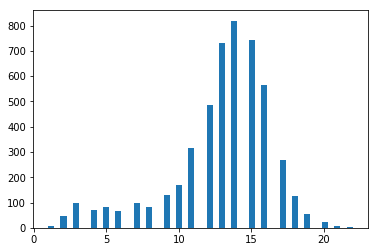

In [64]:
plt.hist(list(map(len,Y)),bins=50);

In [65]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

4997

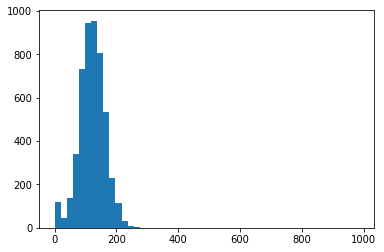

In [66]:
plt.hist(list(map(len,X)),bins=50);

In [67]:
import pickle
with open('data/%s-vocab-embedding.pickle'%FN0,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [68]:
import pickle
with open('data/%s-vocab-embedding.data.pickle'%FN0,'wb') as fp:
    pickle.dump((X,Y),fp,-1)